In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_palette('pastel')
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('marketing_AB.csv', index_col='Unnamed: 0')

In [4]:
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [5]:
df.columns = ['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day', 'most_ads_hour']

In [6]:
df.shape

(588101, 6)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        588101 non-null  int64 
 1   test_group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total_ads      588101 non-null  int64 
 4   most_ads_day   588101 non-null  object
 5   most_ads_hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB


In [8]:
df.duplicated().sum()

0

- Нет дубликатов и отсутствующих значений

In [9]:
df.nunique()

user_id          588101
test_group            2
converted             2
total_ads           807
most_ads_day          7
most_ads_hour        24
dtype: int64

## Visual Data Analysis ##

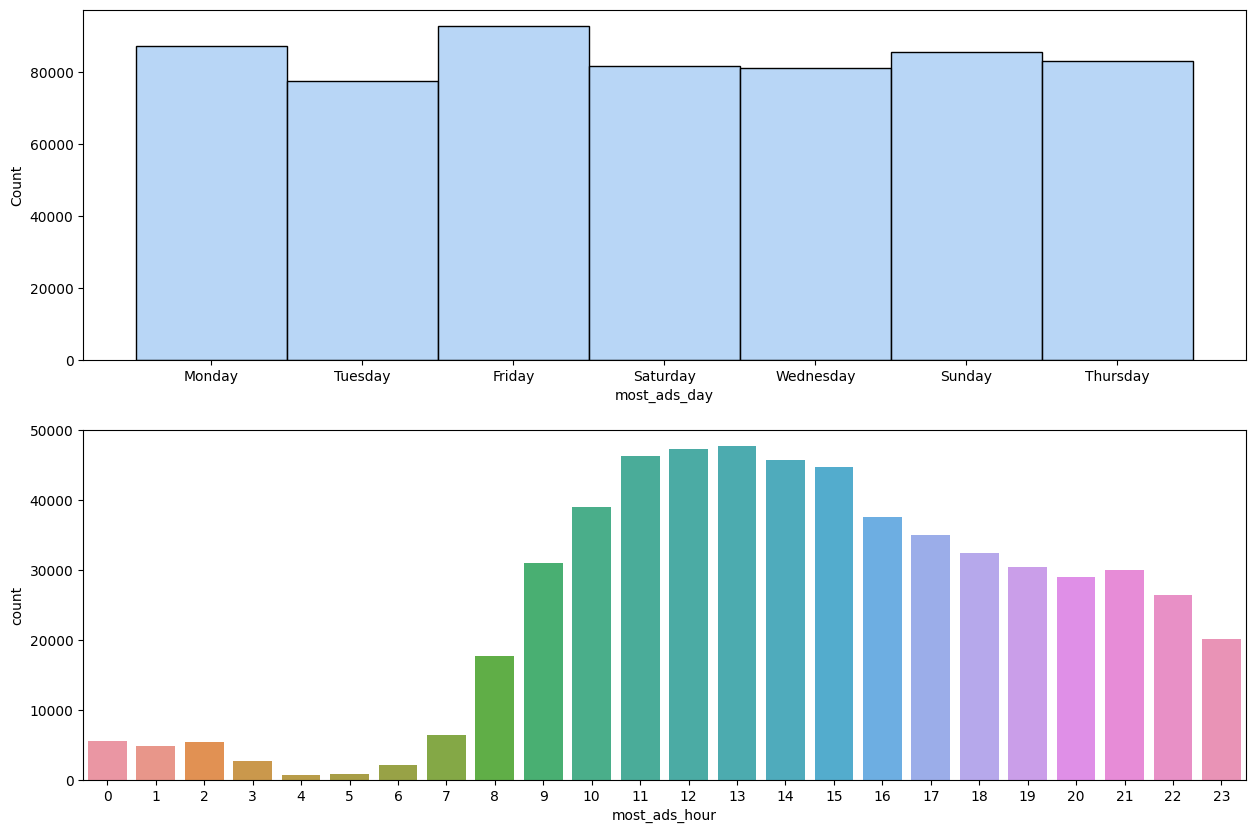

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(15,10))

sns.histplot(df, x='most_ads_day', ax=ax[0]);
sns.countplot(df, x='most_ads_hour', ax=ax[1]);

- Больше всего рекламы пользователи смотрят в понедельник и пятницу
- Час, в который пользователь увидел больше всего рекламы за день, будет между 10:00 и 15:00

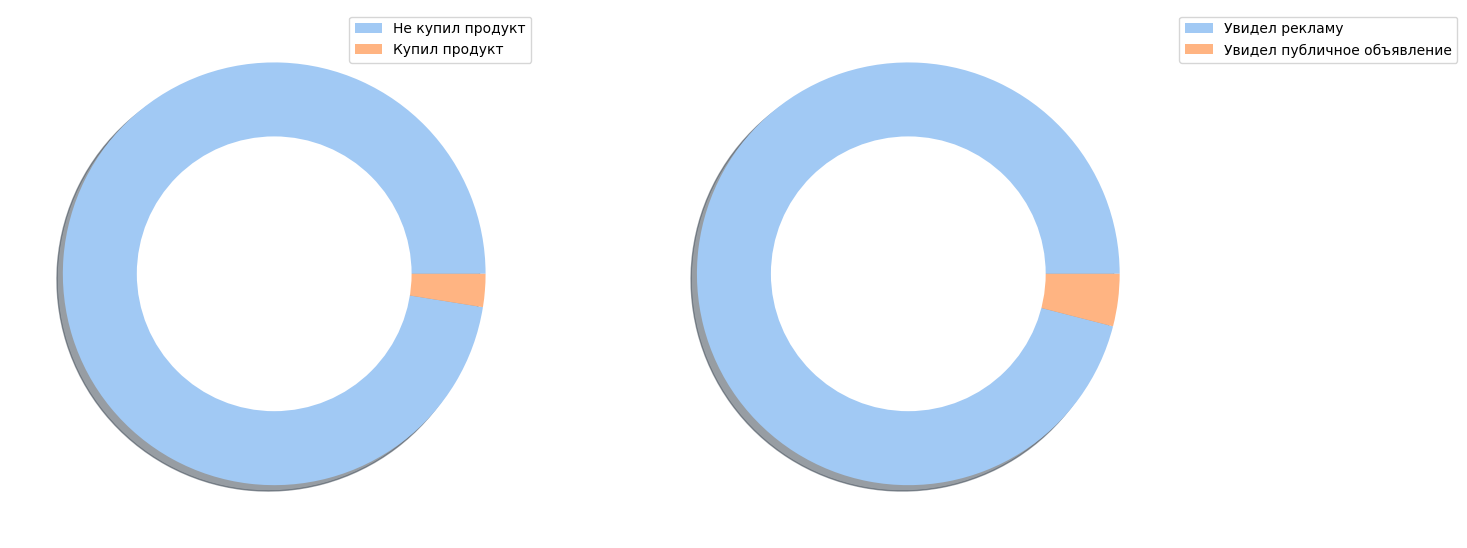

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].pie(df.converted.value_counts(), shadow=True);
ax[0].legend(labels=['Не купил продукт', 'Купил продукт'], bbox_to_anchor=(1,1));

hole = plt.Circle((0, 0), 0.65, facecolor='white');
ax[0].add_artist(hole);

ax[1].pie(df.test_group.value_counts(), shadow=True);
ax[1].legend(labels=['Увидел рекламу', 'Увидел публичное объявление'], bbox_to_anchor=(1,1));

hole = plt.Circle((0, 0), 0.65, facecolor='white');
ax[1].add_artist(hole);

- Рекламу увидели гораздо большее количество людей

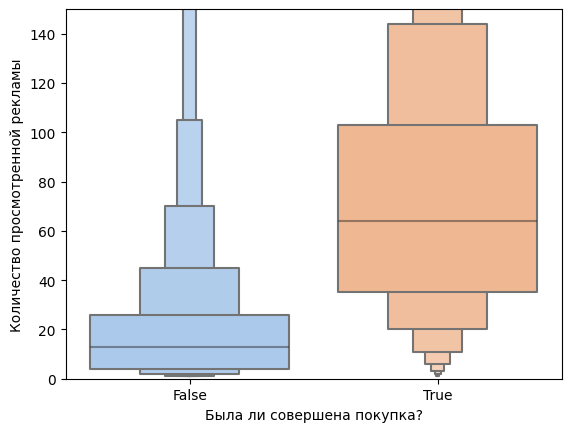

In [12]:
sns.boxenplot(df, x='converted', y='total_ads');
plt.ylim(0,150);
plt.xlabel('Была ли совершена покупка?');
plt.ylabel('Количество просмотренной рекламы');

In [13]:
df.groupby('converted')['total_ads'].median()

converted
False    13.0
True     64.0
Name: total_ads, dtype: float64

- Большое количество выбросов
- Но в среднем совершившие покупку посмотрели почти в 5 раз больше рекламы

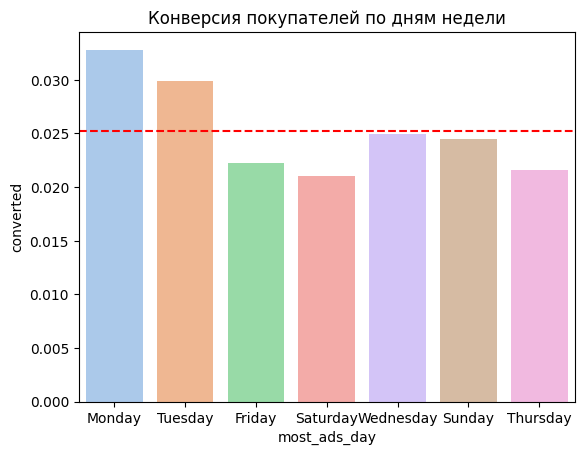

In [14]:
sns.barplot(df, x='most_ads_day', y='converted', errorbar=None);
plt.axhline(df['converted'].mean(), color='r', linestyle='--', label='average');
plt.title('Конверсия покупателей по дням недели');

## A/B test ##

In [17]:
control = df[df['test_group'] == 'psa'] # контрольная группа
treatment = df[df['test_group'] == 'ad'] # тестовая группа

- Посмотрим на распределения групп

In [18]:
treatment.shape

(564577, 6)

In [19]:
ad_converted = np.random.binomial(len(treatment),
                                  df.converted.mean(), 10000) / len(treatment)
psa_converted = np.random.binomial(len(control),
                                   df.converted.mean(), 10000) / len(control)

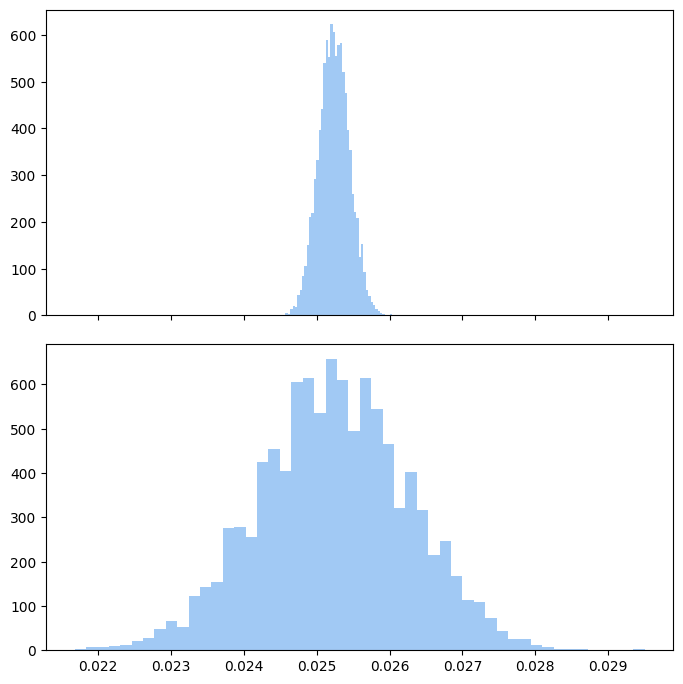

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(7,7), sharex=True)
plt.tight_layout()
ax[0].hist(ad_converted, bins=50 ,align = 'mid');
ax[1].hist(psa_converted, bins=50 ,align = 'mid');

In [21]:
p_diffs = ad_converted - psa_converted
ab_data_diff = treatment['converted'].mean() - control['converted'].mean()
p_diffs.mean(), ab_data_diff

(2.9148612729268026e-06, 0.007692453192201517)

- Нулевая гипотеза: показ рекламы не оказывает никакого эффекта на совершение покупки
- Альтернативная гипотеза: показ рекламы влияет на совершение покупки

In [22]:
if ab_data_diff > 0 : 
    p_value = (p_diffs > ab_data_diff).mean() * 100
else :
    p_value = (p_diffs <= ab_data_diff).mean() * 100
print ( "p_value = ", p_value)

p_value =  0.0


In [23]:
if p_value < 0.05:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не можем отвергнуть нулевую гипотезу')

Отвергаем нулевую гипотезу


- Отвергаем нулевую гипотезу. Между группами обнаружена значительная разница

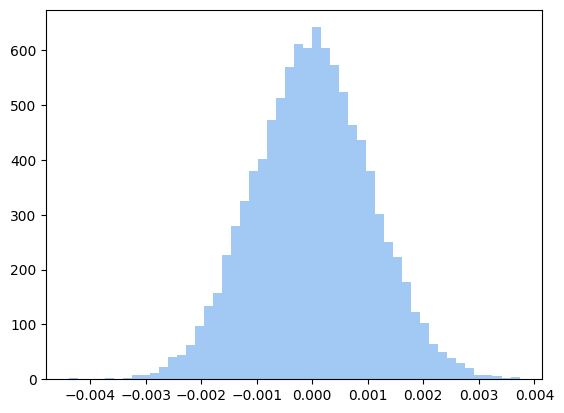

In [24]:
plt.hist(p_diffs, bins=50 ,align = 'mid'); # разница между двумя группами

## T-test ##

In [26]:
from scipy import stats

In [33]:
def t_test(treatment, control):
    t_statistic, p_value = stats.ttest_ind(treatment, control)
    print("Т-статистика:", t_statistic)
    print("P-value:", p_value)

    if p_value < 0.05 :    
        print('Отвергаем нулевую гипотезу, разница между групп значительна')
    else:
        print('Не отвергаем нулевую гипотезу, разница между группами незначительна')

    return t_statistic, p_value

In [34]:
t_statistic, p_value = t_test(treatment["converted"], control["converted"])

Т-статистика: 7.37040597428566
P-value: 1.7033052627831264e-13
Отвергаем нулевую гипотезу, разница между групп значительна


## Chi2-test ##

In [35]:
ct = pd.crosstab(df['test_group'], df['converted'], margins=True)
ct

converted,False,True,All
test_group,,,
ad,550154,14423,564577
psa,23104,420,23524
All,573258,14843,588101


In [36]:
chi2, p_value, dof, expected  =stats.chi2_contingency(ct)

In [37]:
print("Статистика Хи-квадрат", chi2)
print("P-value:", p_value)
print("Число степеней свободы", dof)

Статистика Хи-квадрат 54.318051591383124
P-value: 4.5144265218984724e-11
Число степеней свободы 4


In [38]:
if p_value < 0.05 :    
        print('Отвергаем нулевую гипотезу, разница между групп значительна')
else:
    print('Не отвергаем нулевую гипотезу, разница между группами незначительна')

Отвергаем нулевую гипотезу, разница между групп значительна
